In [2]:
import torch
import numpy as np
from pathlib import Path
import logging
from torch.utils.data import DataLoader
from dataset import ViTacVisDataset
from torch.utils.tensorboard import SummaryWriter
import argparse
from torch import nn
import torch.nn.functional as F

In [3]:
# parser = argparse.ArgumentParser("Train model.")
# parser.add_argument("--epochs", type=int, help="Number of epochs.", required=True)
# parser.add_argument("--data_dir", type=str, help="Path to data.", required=True)
# parser.add_argument(
#     "--checkpoint_dir", type=str, help="Path for saving checkpoints.", required=True
# )

# parser.add_argument("--lr", type=float, help="Learning rate.", required=True)
# parser.add_argument(
#     "--sample_file", type=int, help="Sample number to train from.", required=True
# )
# parser.add_argument(
#     "--batch_size", type=int, help="Batch Size.", required=True
# )

In [17]:
class FLAGS():
    def __init__(self):
        self.data_dir = '/home/tasbolat/some_python_examples/data_VT_SNN/'
        self.batch_size = 8
        self.sample_file = 1
        self.lr = 0.01
        self.epochs = 10000
        self.output_size = 20
args = FLAGS()

In [18]:
device = torch.device("cuda:1")

In [19]:
train_dataset = ViTacVisDataset(
    path=args.data_dir, sample_file=f"train_80_20_{args.sample_file}.txt", output_size=args.output_size
)
train_loader = DataLoader(
    dataset=train_dataset, batch_size=args.batch_size, shuffle=False, num_workers=4
)
test_dataset = ViTacVisDataset(
    path=args.data_dir, sample_file=f"test_80_20_{args.sample_file}.txt", output_size=args.output_size
)
test_loader = DataLoader(
    dataset=test_dataset, batch_size=args.batch_size, shuffle=False, num_workers=4
)

In [43]:
# define NN models
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=2, out_channels=4, kernel_size=(3,3), stride=(2,2))
        self.conv2 = nn.Conv2d(in_channels=4, out_channels=8, kernel_size=(3,3), stride=(1,1))

    def forward(self, x):
#         print('CNN input:', x.shape)
        x = self.conv1(x)
        # print('Conv', x.size()) 
        x = F.max_pool2d(x, 2)
        #print('Pool 1', x.size())
        x = F.relu(x)
        
        x = self.conv2(x)
        # print('Conv', x.size()) 
        x = F.max_pool2d(x, 2)
        #print('Pool 2', x.size())
        x = F.relu(x)
        x = x.view(-1, 8*5*6)
        return x

In [51]:
class CNN_LSTM(nn.Module):

    def __init__(self):
        
        super(CNN_LSTM, self).__init__()
        self.input_size = 240
        self.hidden_dim = 50
        self.num_layers = 1
        
        self.cnn = CNN()

        # Define the LSTM layer
        self.gru = nn.GRU(self.input_size, self.hidden_dim, self.num_layers)

        # Define the output layer
        self.fc = nn.Linear(self.hidden_dim, 20)
        
        #self.fc_mlp = nn.Linear(6300, self.input_size)

    def forward(self, x):
        
        #print('Model input ', x.size())
        batch_size, C, H, W, sequence_size = x.size()
        
        # create CNN embedding
        cnn_embed_seq = []
        for t in range(sequence_size):
            cnn_out = self.cnn(x[...,t])
            cnn_embed_seq.append(cnn_out)
        
        cnn_embed_seq = torch.stack(cnn_embed_seq, dim=0)
        #print('cnn_embed_seq: ', cnn_embed_seq.shape)
        
        # forward on GRU
        # (seq_len, batch, input_size)
        gru_out, hidden = self.gru(cnn_embed_seq)
        #print('gru out: ', gru_out.shape)
        
        
        # Only take the output from the final timetep
        # Can pass on the entirety of lstm_out to the next layer if it is a seq2seq prediction
        y_pred = self.fc(gru_out[-1, :, :])
        
        #print(y_pred.shape)
        return y_pred

In [52]:
net = CNN_LSTM().to(device)
# Create snn loss instance.
criterion = nn.CrossEntropyLoss()
# Define optimizer module.
optimizer = torch.optim.RMSprop(
    net.parameters(), lr=0.0001)

In [53]:
train_accs = []
test_accs = []
train_loss = []
test_loss = []
for epoch in range(args.epochs):
    # Training loop.
    net.train()
    correct = 0
    batch_loss = 0
    train_acc = 0
    for i, (in_viz, _, label) in enumerate(train_loader, 0):

        in_viz = in_viz.to(device)
        label = label.to(device)
        # Forward pass of the network.
        #print(in_viz.shape)
        out = net.forward(in_viz)
        #print(out_tact.shape)
        # Calculate loss.
        #print(label.shape)
        loss = criterion(out, label)
        #print(loss)

        batch_loss += loss.cpu().data.item()
        # Reset gradients to zero.
        optimizer.zero_grad()
        # Backward pass of the network.
        loss.backward()
        # Update weights.
        optimizer.step()

        _, predicted = torch.max(out.data, 1)
        correct += (predicted == label).sum().item()

    # Reset training stats.
    train_acc = correct/len(train_loader.dataset)
    train_loss.append(batch_loss)
    train_accs.append(train_acc)
    #print(train_acc, batch_loss)

    # testing
    net.eval()
    correct = 0
    batch_loss = 0
    test_acc = 0
    with torch.no_grad():
        for i, (in_viz, _, label) in enumerate(test_loader, 0):
            in_viz = in_viz.to(device)
            # Forward pass of the network.
            out = net.forward(in_viz)
            label = label.to(device)
            _, predicted = torch.max(out.data, 1)
            correct += (predicted == label).sum().item()
            # Calculate loss.
            loss = criterion(out, label)
            batch_loss += loss.cpu().data.item()

    test_loss.append(batch_loss)
    test_acc = correct/len(test_loader.dataset)
    test_accs.append(test_acc)
    if epoch%1 == 0:
        print(epoch, 'Train:', train_acc, 'Test:', test_acc)

0 Train: 0.0875 Test: 0.1
1 Train: 0.1 Test: 0.1
2 Train: 0.1 Test: 0.1
3 Train: 0.1 Test: 0.1
4 Train: 0.1 Test: 0.1
5 Train: 0.09583333333333334 Test: 0.1
6 Train: 0.10416666666666667 Test: 0.13333333333333333
7 Train: 0.10416666666666667 Test: 0.13333333333333333
8 Train: 0.10833333333333334 Test: 0.13333333333333333
9 Train: 0.12916666666666668 Test: 0.11666666666666667
10 Train: 0.13333333333333333 Test: 0.11666666666666667
11 Train: 0.13333333333333333 Test: 0.11666666666666667
12 Train: 0.15416666666666667 Test: 0.15
13 Train: 0.16666666666666666 Test: 0.15
14 Train: 0.19166666666666668 Test: 0.18333333333333332
15 Train: 0.21666666666666667 Test: 0.2
16 Train: 0.23333333333333334 Test: 0.2
17 Train: 0.24583333333333332 Test: 0.2
18 Train: 0.25416666666666665 Test: 0.21666666666666667
19 Train: 0.2625 Test: 0.18333333333333332
20 Train: 0.2708333333333333 Test: 0.18333333333333332
21 Train: 0.2916666666666667 Test: 0.16666666666666666
22 Train: 0.3 Test: 0.16666666666666666
23 T

180 Train: 0.9416666666666667 Test: 0.2
181 Train: 0.9375 Test: 0.21666666666666667
182 Train: 0.9416666666666667 Test: 0.2
183 Train: 0.9458333333333333 Test: 0.21666666666666667
184 Train: 0.9458333333333333 Test: 0.2
185 Train: 0.95 Test: 0.21666666666666667
186 Train: 0.95 Test: 0.18333333333333332
187 Train: 0.9541666666666667 Test: 0.2
188 Train: 0.9583333333333334 Test: 0.21666666666666667
189 Train: 0.9583333333333334 Test: 0.2
190 Train: 0.9625 Test: 0.21666666666666667
191 Train: 0.9583333333333334 Test: 0.2
192 Train: 0.9583333333333334 Test: 0.18333333333333332
193 Train: 0.9666666666666667 Test: 0.2
194 Train: 0.9666666666666667 Test: 0.21666666666666667
195 Train: 0.9625 Test: 0.2
196 Train: 0.9666666666666667 Test: 0.21666666666666667
197 Train: 0.9666666666666667 Test: 0.2
198 Train: 0.9666666666666667 Test: 0.2
199 Train: 0.9625 Test: 0.21666666666666667
200 Train: 0.9666666666666667 Test: 0.21666666666666667
201 Train: 0.9666666666666667 Test: 0.21666666666666667
202 

381 Train: 1.0 Test: 0.16666666666666666
382 Train: 1.0 Test: 0.16666666666666666
383 Train: 1.0 Test: 0.16666666666666666
384 Train: 1.0 Test: 0.16666666666666666
385 Train: 1.0 Test: 0.16666666666666666
386 Train: 1.0 Test: 0.16666666666666666
387 Train: 1.0 Test: 0.16666666666666666
388 Train: 1.0 Test: 0.16666666666666666
389 Train: 1.0 Test: 0.16666666666666666
390 Train: 1.0 Test: 0.16666666666666666
391 Train: 1.0 Test: 0.16666666666666666
392 Train: 1.0 Test: 0.16666666666666666
393 Train: 1.0 Test: 0.16666666666666666
394 Train: 1.0 Test: 0.16666666666666666
395 Train: 1.0 Test: 0.16666666666666666
396 Train: 1.0 Test: 0.16666666666666666
397 Train: 1.0 Test: 0.16666666666666666
398 Train: 1.0 Test: 0.16666666666666666
399 Train: 1.0 Test: 0.16666666666666666
400 Train: 1.0 Test: 0.16666666666666666
401 Train: 1.0 Test: 0.16666666666666666
402 Train: 1.0 Test: 0.16666666666666666
403 Train: 1.0 Test: 0.16666666666666666
404 Train: 1.0 Test: 0.16666666666666666
405 Train: 1.0 T

584 Train: 1.0 Test: 0.15
585 Train: 1.0 Test: 0.15
586 Train: 1.0 Test: 0.15
587 Train: 1.0 Test: 0.15
588 Train: 1.0 Test: 0.15
589 Train: 1.0 Test: 0.15
590 Train: 1.0 Test: 0.15
591 Train: 1.0 Test: 0.15
592 Train: 1.0 Test: 0.15
593 Train: 1.0 Test: 0.15
594 Train: 1.0 Test: 0.15
595 Train: 1.0 Test: 0.15
596 Train: 1.0 Test: 0.15
597 Train: 1.0 Test: 0.15
598 Train: 1.0 Test: 0.15
599 Train: 1.0 Test: 0.15
600 Train: 1.0 Test: 0.15
601 Train: 1.0 Test: 0.15
602 Train: 1.0 Test: 0.15
603 Train: 1.0 Test: 0.15
604 Train: 1.0 Test: 0.15
605 Train: 1.0 Test: 0.15
606 Train: 1.0 Test: 0.15
607 Train: 1.0 Test: 0.15
608 Train: 1.0 Test: 0.15
609 Train: 1.0 Test: 0.13333333333333333
610 Train: 1.0 Test: 0.15
611 Train: 1.0 Test: 0.13333333333333333
612 Train: 1.0 Test: 0.15
613 Train: 1.0 Test: 0.13333333333333333
614 Train: 1.0 Test: 0.13333333333333333
615 Train: 1.0 Test: 0.13333333333333333
616 Train: 1.0 Test: 0.13333333333333333
617 Train: 1.0 Test: 0.13333333333333333
618 Train: 

807 Train: 1.0 Test: 0.13333333333333333
808 Train: 1.0 Test: 0.13333333333333333
809 Train: 1.0 Test: 0.13333333333333333
810 Train: 1.0 Test: 0.13333333333333333
811 Train: 1.0 Test: 0.11666666666666667
812 Train: 1.0 Test: 0.11666666666666667
813 Train: 1.0 Test: 0.11666666666666667
814 Train: 1.0 Test: 0.13333333333333333
815 Train: 1.0 Test: 0.13333333333333333
816 Train: 1.0 Test: 0.13333333333333333
817 Train: 1.0 Test: 0.11666666666666667
818 Train: 1.0 Test: 0.11666666666666667
819 Train: 1.0 Test: 0.11666666666666667
820 Train: 1.0 Test: 0.11666666666666667
821 Train: 1.0 Test: 0.13333333333333333
822 Train: 1.0 Test: 0.11666666666666667
823 Train: 1.0 Test: 0.15
824 Train: 1.0 Test: 0.15
825 Train: 1.0 Test: 0.15
826 Train: 1.0 Test: 0.15
827 Train: 1.0 Test: 0.15
828 Train: 1.0 Test: 0.15
829 Train: 1.0 Test: 0.15
830 Train: 1.0 Test: 0.15
831 Train: 1.0 Test: 0.15
832 Train: 1.0 Test: 0.15
833 Train: 1.0 Test: 0.15
834 Train: 1.0 Test: 0.15
835 Train: 1.0 Test: 0.15
836 Tr

1048 Train: 1.0 Test: 0.13333333333333333
1049 Train: 1.0 Test: 0.13333333333333333
1050 Train: 1.0 Test: 0.15
1051 Train: 1.0 Test: 0.15
1052 Train: 1.0 Test: 0.15
1053 Train: 1.0 Test: 0.11666666666666667
1054 Train: 1.0 Test: 0.11666666666666667
1055 Train: 1.0 Test: 0.13333333333333333
1056 Train: 1.0 Test: 0.13333333333333333
1057 Train: 1.0 Test: 0.13333333333333333
1058 Train: 1.0 Test: 0.13333333333333333
1059 Train: 1.0 Test: 0.1
1060 Train: 1.0 Test: 0.13333333333333333
1061 Train: 1.0 Test: 0.13333333333333333
1062 Train: 1.0 Test: 0.15
1063 Train: 1.0 Test: 0.13333333333333333
1064 Train: 1.0 Test: 0.11666666666666667
1065 Train: 1.0 Test: 0.11666666666666667
1066 Train: 1.0 Test: 0.11666666666666667
1067 Train: 1.0 Test: 0.13333333333333333
1068 Train: 1.0 Test: 0.11666666666666667
1069 Train: 1.0 Test: 0.11666666666666667
1070 Train: 1.0 Test: 0.15
1071 Train: 1.0 Test: 0.11666666666666667
1072 Train: 1.0 Test: 0.13333333333333333
1073 Train: 1.0 Test: 0.13333333333333333

1262 Train: 1.0 Test: 0.11666666666666667
1263 Train: 1.0 Test: 0.13333333333333333
1264 Train: 1.0 Test: 0.11666666666666667
1265 Train: 1.0 Test: 0.11666666666666667
1266 Train: 1.0 Test: 0.11666666666666667
1267 Train: 1.0 Test: 0.11666666666666667
1268 Train: 1.0 Test: 0.15
1269 Train: 1.0 Test: 0.11666666666666667
1270 Train: 1.0 Test: 0.11666666666666667
1271 Train: 1.0 Test: 0.11666666666666667
1272 Train: 1.0 Test: 0.13333333333333333
1273 Train: 1.0 Test: 0.11666666666666667
1274 Train: 1.0 Test: 0.11666666666666667
1275 Train: 1.0 Test: 0.11666666666666667
1276 Train: 1.0 Test: 0.11666666666666667
1277 Train: 1.0 Test: 0.11666666666666667
1278 Train: 1.0 Test: 0.13333333333333333
1279 Train: 1.0 Test: 0.13333333333333333
1280 Train: 1.0 Test: 0.11666666666666667
1281 Train: 1.0 Test: 0.11666666666666667
1282 Train: 1.0 Test: 0.13333333333333333
1283 Train: 1.0 Test: 0.11666666666666667
1284 Train: 1.0 Test: 0.11666666666666667
1285 Train: 1.0 Test: 0.11666666666666667
1286 Tr

1483 Train: 1.0 Test: 0.15
1484 Train: 1.0 Test: 0.15
1485 Train: 1.0 Test: 0.13333333333333333
1486 Train: 1.0 Test: 0.13333333333333333
1487 Train: 1.0 Test: 0.13333333333333333
1488 Train: 1.0 Test: 0.13333333333333333
1489 Train: 1.0 Test: 0.13333333333333333
1490 Train: 1.0 Test: 0.13333333333333333
1491 Train: 1.0 Test: 0.13333333333333333
1492 Train: 1.0 Test: 0.15
1493 Train: 1.0 Test: 0.13333333333333333
1494 Train: 1.0 Test: 0.13333333333333333
1495 Train: 1.0 Test: 0.13333333333333333
1496 Train: 1.0 Test: 0.13333333333333333
1497 Train: 1.0 Test: 0.11666666666666667
1498 Train: 1.0 Test: 0.11666666666666667
1499 Train: 1.0 Test: 0.11666666666666667
1500 Train: 1.0 Test: 0.11666666666666667
1501 Train: 1.0 Test: 0.13333333333333333
1502 Train: 1.0 Test: 0.13333333333333333
1503 Train: 1.0 Test: 0.13333333333333333
1504 Train: 1.0 Test: 0.11666666666666667
1505 Train: 1.0 Test: 0.1
1506 Train: 1.0 Test: 0.11666666666666667
1507 Train: 1.0 Test: 0.1
1508 Train: 1.0 Test: 0.116

1700 Train: 1.0 Test: 0.11666666666666667
1701 Train: 1.0 Test: 0.13333333333333333
1702 Train: 1.0 Test: 0.13333333333333333
1703 Train: 1.0 Test: 0.13333333333333333
1704 Train: 1.0 Test: 0.13333333333333333
1705 Train: 1.0 Test: 0.11666666666666667
1706 Train: 1.0 Test: 0.13333333333333333
1707 Train: 1.0 Test: 0.15
1708 Train: 1.0 Test: 0.13333333333333333
1709 Train: 1.0 Test: 0.13333333333333333
1710 Train: 1.0 Test: 0.13333333333333333
1711 Train: 1.0 Test: 0.13333333333333333
1712 Train: 1.0 Test: 0.13333333333333333
1713 Train: 1.0 Test: 0.13333333333333333
1714 Train: 1.0 Test: 0.13333333333333333
1715 Train: 1.0 Test: 0.13333333333333333
1716 Train: 1.0 Test: 0.13333333333333333
1717 Train: 1.0 Test: 0.13333333333333333
1718 Train: 1.0 Test: 0.15
1719 Train: 1.0 Test: 0.13333333333333333
1720 Train: 1.0 Test: 0.13333333333333333
1721 Train: 1.0 Test: 0.11666666666666667
1722 Train: 1.0 Test: 0.11666666666666667
1723 Train: 1.0 Test: 0.1
1724 Train: 1.0 Test: 0.13333333333333

1938 Train: 1.0 Test: 0.15
1939 Train: 1.0 Test: 0.15
1940 Train: 1.0 Test: 0.13333333333333333
1941 Train: 1.0 Test: 0.15
1942 Train: 1.0 Test: 0.13333333333333333
1943 Train: 1.0 Test: 0.15
1944 Train: 1.0 Test: 0.13333333333333333
1945 Train: 1.0 Test: 0.13333333333333333
1946 Train: 1.0 Test: 0.15
1947 Train: 1.0 Test: 0.13333333333333333
1948 Train: 1.0 Test: 0.15
1949 Train: 1.0 Test: 0.11666666666666667
1950 Train: 1.0 Test: 0.13333333333333333
1951 Train: 1.0 Test: 0.13333333333333333
1952 Train: 1.0 Test: 0.13333333333333333
1953 Train: 1.0 Test: 0.13333333333333333
1954 Train: 1.0 Test: 0.13333333333333333
1955 Train: 1.0 Test: 0.13333333333333333
1956 Train: 1.0 Test: 0.11666666666666667
1957 Train: 1.0 Test: 0.13333333333333333
1958 Train: 1.0 Test: 0.13333333333333333
1959 Train: 1.0 Test: 0.15
1960 Train: 1.0 Test: 0.13333333333333333
1961 Train: 1.0 Test: 0.13333333333333333
1962 Train: 1.0 Test: 0.13333333333333333
1963 Train: 1.0 Test: 0.13333333333333333
1964 Train: 1

2150 Train: 1.0 Test: 0.16666666666666666
2151 Train: 1.0 Test: 0.16666666666666666
2152 Train: 1.0 Test: 0.16666666666666666
2153 Train: 1.0 Test: 0.18333333333333332
2154 Train: 1.0 Test: 0.16666666666666666
2155 Train: 1.0 Test: 0.16666666666666666
2156 Train: 1.0 Test: 0.18333333333333332
2157 Train: 1.0 Test: 0.16666666666666666
2158 Train: 1.0 Test: 0.16666666666666666
2159 Train: 1.0 Test: 0.16666666666666666
2160 Train: 1.0 Test: 0.15
2161 Train: 1.0 Test: 0.16666666666666666
2162 Train: 1.0 Test: 0.16666666666666666
2163 Train: 1.0 Test: 0.15
2164 Train: 1.0 Test: 0.15
2165 Train: 1.0 Test: 0.13333333333333333
2166 Train: 1.0 Test: 0.15
2167 Train: 1.0 Test: 0.13333333333333333
2168 Train: 1.0 Test: 0.15
2169 Train: 1.0 Test: 0.15
2170 Train: 1.0 Test: 0.13333333333333333
2171 Train: 1.0 Test: 0.13333333333333333
2172 Train: 1.0 Test: 0.15
2173 Train: 1.0 Test: 0.15
2174 Train: 1.0 Test: 0.16666666666666666
2175 Train: 1.0 Test: 0.15
2176 Train: 1.0 Test: 0.16666666666666666
2

2396 Train: 1.0 Test: 0.15
2397 Train: 1.0 Test: 0.15
2398 Train: 1.0 Test: 0.15
2399 Train: 1.0 Test: 0.15
2400 Train: 1.0 Test: 0.15
2401 Train: 1.0 Test: 0.15
2402 Train: 1.0 Test: 0.16666666666666666
2403 Train: 1.0 Test: 0.15
2404 Train: 1.0 Test: 0.15
2405 Train: 1.0 Test: 0.15
2406 Train: 1.0 Test: 0.16666666666666666
2407 Train: 1.0 Test: 0.16666666666666666
2408 Train: 1.0 Test: 0.16666666666666666
2409 Train: 1.0 Test: 0.18333333333333332
2410 Train: 1.0 Test: 0.15
2411 Train: 1.0 Test: 0.16666666666666666
2412 Train: 1.0 Test: 0.15
2413 Train: 1.0 Test: 0.16666666666666666
2414 Train: 1.0 Test: 0.15
2415 Train: 1.0 Test: 0.15
2416 Train: 1.0 Test: 0.15
2417 Train: 1.0 Test: 0.15
2418 Train: 1.0 Test: 0.16666666666666666
2419 Train: 1.0 Test: 0.16666666666666666
2420 Train: 1.0 Test: 0.16666666666666666
2421 Train: 1.0 Test: 0.15
2422 Train: 1.0 Test: 0.16666666666666666
2423 Train: 1.0 Test: 0.16666666666666666
2424 Train: 1.0 Test: 0.15
2425 Train: 1.0 Test: 0.1666666666666

2642 Train: 1.0 Test: 0.15
2643 Train: 1.0 Test: 0.15
2644 Train: 1.0 Test: 0.15
2645 Train: 1.0 Test: 0.15
2646 Train: 1.0 Test: 0.15
2647 Train: 1.0 Test: 0.15
2648 Train: 1.0 Test: 0.16666666666666666
2649 Train: 1.0 Test: 0.15
2650 Train: 1.0 Test: 0.15
2651 Train: 1.0 Test: 0.15
2652 Train: 1.0 Test: 0.15
2653 Train: 1.0 Test: 0.15
2654 Train: 1.0 Test: 0.15
2655 Train: 1.0 Test: 0.16666666666666666
2656 Train: 1.0 Test: 0.15
2657 Train: 1.0 Test: 0.15
2658 Train: 1.0 Test: 0.15
2659 Train: 1.0 Test: 0.15
2660 Train: 1.0 Test: 0.15
2661 Train: 1.0 Test: 0.15
2662 Train: 1.0 Test: 0.15
2663 Train: 1.0 Test: 0.15
2664 Train: 1.0 Test: 0.15
2665 Train: 1.0 Test: 0.15
2666 Train: 1.0 Test: 0.15
2667 Train: 1.0 Test: 0.16666666666666666
2668 Train: 1.0 Test: 0.16666666666666666
2669 Train: 1.0 Test: 0.15
2670 Train: 1.0 Test: 0.15
2671 Train: 1.0 Test: 0.16666666666666666
2672 Train: 1.0 Test: 0.15
2673 Train: 1.0 Test: 0.15
2674 Train: 1.0 Test: 0.16666666666666666
2675 Train: 1.0 Tes

2866 Train: 1.0 Test: 0.18333333333333332
2867 Train: 1.0 Test: 0.18333333333333332
2868 Train: 1.0 Test: 0.2
2869 Train: 1.0 Test: 0.18333333333333332
2870 Train: 1.0 Test: 0.18333333333333332
2871 Train: 1.0 Test: 0.18333333333333332
2872 Train: 1.0 Test: 0.18333333333333332
2873 Train: 1.0 Test: 0.2
2874 Train: 1.0 Test: 0.18333333333333332
2875 Train: 1.0 Test: 0.2
2876 Train: 1.0 Test: 0.16666666666666666
2877 Train: 1.0 Test: 0.2
2878 Train: 1.0 Test: 0.2
2879 Train: 1.0 Test: 0.18333333333333332
2880 Train: 1.0 Test: 0.18333333333333332
2881 Train: 1.0 Test: 0.18333333333333332
2882 Train: 1.0 Test: 0.18333333333333332
2883 Train: 1.0 Test: 0.18333333333333332
2884 Train: 1.0 Test: 0.18333333333333332
2885 Train: 1.0 Test: 0.18333333333333332
2886 Train: 1.0 Test: 0.2
2887 Train: 1.0 Test: 0.16666666666666666
2888 Train: 1.0 Test: 0.18333333333333332
2889 Train: 1.0 Test: 0.18333333333333332
2890 Train: 1.0 Test: 0.2
2891 Train: 1.0 Test: 0.2
2892 Train: 1.0 Test: 0.183333333333

3082 Train: 1.0 Test: 0.16666666666666666
3083 Train: 1.0 Test: 0.16666666666666666
3084 Train: 1.0 Test: 0.18333333333333332
3085 Train: 1.0 Test: 0.18333333333333332
3086 Train: 1.0 Test: 0.18333333333333332
3087 Train: 1.0 Test: 0.18333333333333332
3088 Train: 1.0 Test: 0.18333333333333332
3089 Train: 1.0 Test: 0.18333333333333332
3090 Train: 1.0 Test: 0.18333333333333332
3091 Train: 1.0 Test: 0.18333333333333332
3092 Train: 1.0 Test: 0.18333333333333332
3093 Train: 1.0 Test: 0.18333333333333332
3094 Train: 1.0 Test: 0.18333333333333332
3095 Train: 1.0 Test: 0.18333333333333332
3096 Train: 1.0 Test: 0.18333333333333332
3097 Train: 1.0 Test: 0.18333333333333332
3098 Train: 1.0 Test: 0.18333333333333332
3099 Train: 1.0 Test: 0.18333333333333332
3100 Train: 1.0 Test: 0.18333333333333332
3101 Train: 1.0 Test: 0.18333333333333332
3102 Train: 1.0 Test: 0.18333333333333332
3103 Train: 1.0 Test: 0.18333333333333332
3104 Train: 1.0 Test: 0.16666666666666666
3105 Train: 1.0 Test: 0.1666666666

3323 Train: 1.0 Test: 0.15
3324 Train: 1.0 Test: 0.13333333333333333
3325 Train: 1.0 Test: 0.13333333333333333
3326 Train: 1.0 Test: 0.13333333333333333
3327 Train: 1.0 Test: 0.13333333333333333
3328 Train: 1.0 Test: 0.13333333333333333
3329 Train: 1.0 Test: 0.13333333333333333
3330 Train: 1.0 Test: 0.13333333333333333
3331 Train: 1.0 Test: 0.13333333333333333
3332 Train: 1.0 Test: 0.13333333333333333
3333 Train: 1.0 Test: 0.13333333333333333
3334 Train: 1.0 Test: 0.13333333333333333
3335 Train: 1.0 Test: 0.13333333333333333
3336 Train: 1.0 Test: 0.13333333333333333
3337 Train: 1.0 Test: 0.13333333333333333
3338 Train: 1.0 Test: 0.13333333333333333
3339 Train: 1.0 Test: 0.13333333333333333
3340 Train: 1.0 Test: 0.13333333333333333
3341 Train: 1.0 Test: 0.11666666666666667
3342 Train: 1.0 Test: 0.11666666666666667
3343 Train: 1.0 Test: 0.13333333333333333
3344 Train: 1.0 Test: 0.13333333333333333
3345 Train: 1.0 Test: 0.13333333333333333
3346 Train: 1.0 Test: 0.11666666666666667
3347 Tr

3520 Train: 1.0 Test: 0.13333333333333333
3521 Train: 1.0 Test: 0.13333333333333333
3522 Train: 1.0 Test: 0.13333333333333333
3523 Train: 1.0 Test: 0.13333333333333333
3524 Train: 1.0 Test: 0.13333333333333333
3525 Train: 1.0 Test: 0.13333333333333333
3526 Train: 1.0 Test: 0.13333333333333333
3527 Train: 1.0 Test: 0.13333333333333333
3528 Train: 1.0 Test: 0.13333333333333333
3529 Train: 1.0 Test: 0.13333333333333333
3530 Train: 1.0 Test: 0.13333333333333333
3531 Train: 1.0 Test: 0.13333333333333333
3532 Train: 1.0 Test: 0.13333333333333333
3533 Train: 1.0 Test: 0.13333333333333333
3534 Train: 1.0 Test: 0.13333333333333333
3535 Train: 1.0 Test: 0.13333333333333333
3536 Train: 1.0 Test: 0.13333333333333333
3537 Train: 1.0 Test: 0.13333333333333333
3538 Train: 1.0 Test: 0.13333333333333333
3539 Train: 1.0 Test: 0.13333333333333333
3540 Train: 1.0 Test: 0.13333333333333333
3541 Train: 1.0 Test: 0.13333333333333333
3542 Train: 1.0 Test: 0.13333333333333333
3543 Train: 1.0 Test: 0.1333333333

3723 Train: 1.0 Test: 0.13333333333333333
3724 Train: 1.0 Test: 0.13333333333333333
3725 Train: 1.0 Test: 0.15
3726 Train: 1.0 Test: 0.13333333333333333
3727 Train: 1.0 Test: 0.13333333333333333
3728 Train: 1.0 Test: 0.13333333333333333
3729 Train: 1.0 Test: 0.15
3730 Train: 1.0 Test: 0.13333333333333333
3731 Train: 1.0 Test: 0.13333333333333333
3732 Train: 1.0 Test: 0.13333333333333333
3733 Train: 1.0 Test: 0.15
3734 Train: 1.0 Test: 0.15
3735 Train: 1.0 Test: 0.15
3736 Train: 1.0 Test: 0.13333333333333333
3737 Train: 1.0 Test: 0.13333333333333333
3738 Train: 1.0 Test: 0.15
3739 Train: 1.0 Test: 0.15
3740 Train: 1.0 Test: 0.15
3741 Train: 1.0 Test: 0.15
3742 Train: 1.0 Test: 0.15
3743 Train: 1.0 Test: 0.13333333333333333
3744 Train: 1.0 Test: 0.13333333333333333
3745 Train: 1.0 Test: 0.13333333333333333
3746 Train: 1.0 Test: 0.13333333333333333
3747 Train: 1.0 Test: 0.15
3748 Train: 1.0 Test: 0.13333333333333333
3749 Train: 1.0 Test: 0.13333333333333333
3750 Train: 1.0 Test: 0.15
3751

3931 Train: 1.0 Test: 0.18333333333333332
3932 Train: 1.0 Test: 0.18333333333333332
3933 Train: 1.0 Test: 0.18333333333333332
3934 Train: 1.0 Test: 0.18333333333333332
3935 Train: 1.0 Test: 0.18333333333333332
3936 Train: 1.0 Test: 0.18333333333333332
3937 Train: 1.0 Test: 0.15
3938 Train: 1.0 Test: 0.18333333333333332
3939 Train: 1.0 Test: 0.15
3940 Train: 1.0 Test: 0.16666666666666666
3941 Train: 1.0 Test: 0.15
3942 Train: 1.0 Test: 0.15
3943 Train: 1.0 Test: 0.16666666666666666
3944 Train: 1.0 Test: 0.18333333333333332
3945 Train: 1.0 Test: 0.16666666666666666
3946 Train: 1.0 Test: 0.16666666666666666
3947 Train: 1.0 Test: 0.18333333333333332
3948 Train: 1.0 Test: 0.18333333333333332
3949 Train: 1.0 Test: 0.18333333333333332
3950 Train: 1.0 Test: 0.16666666666666666
3951 Train: 1.0 Test: 0.18333333333333332
3952 Train: 1.0 Test: 0.15
3953 Train: 1.0 Test: 0.16666666666666666
3954 Train: 1.0 Test: 0.15
3955 Train: 1.0 Test: 0.15
3956 Train: 1.0 Test: 0.18333333333333332
3957 Train: 1

4142 Train: 1.0 Test: 0.2
4143 Train: 1.0 Test: 0.16666666666666666
4144 Train: 1.0 Test: 0.16666666666666666
4145 Train: 1.0 Test: 0.16666666666666666
4146 Train: 1.0 Test: 0.16666666666666666
4147 Train: 1.0 Test: 0.16666666666666666
4148 Train: 1.0 Test: 0.18333333333333332
4149 Train: 1.0 Test: 0.18333333333333332
4150 Train: 1.0 Test: 0.18333333333333332
4151 Train: 1.0 Test: 0.18333333333333332
4152 Train: 1.0 Test: 0.18333333333333332
4153 Train: 1.0 Test: 0.18333333333333332
4154 Train: 1.0 Test: 0.18333333333333332
4155 Train: 1.0 Test: 0.18333333333333332
4156 Train: 1.0 Test: 0.18333333333333332
4157 Train: 1.0 Test: 0.18333333333333332
4158 Train: 1.0 Test: 0.18333333333333332
4159 Train: 1.0 Test: 0.18333333333333332
4160 Train: 1.0 Test: 0.18333333333333332
4161 Train: 1.0 Test: 0.18333333333333332
4162 Train: 1.0 Test: 0.18333333333333332
4163 Train: 1.0 Test: 0.18333333333333332
4164 Train: 1.0 Test: 0.18333333333333332
4165 Train: 1.0 Test: 0.18333333333333332
4166 Tra

4376 Train: 1.0 Test: 0.18333333333333332
4377 Train: 1.0 Test: 0.2
4378 Train: 1.0 Test: 0.18333333333333332
4379 Train: 1.0 Test: 0.18333333333333332
4380 Train: 1.0 Test: 0.16666666666666666
4381 Train: 1.0 Test: 0.16666666666666666
4382 Train: 1.0 Test: 0.2
4383 Train: 1.0 Test: 0.18333333333333332
4384 Train: 1.0 Test: 0.18333333333333332
4385 Train: 1.0 Test: 0.2
4386 Train: 1.0 Test: 0.2
4387 Train: 1.0 Test: 0.15
4388 Train: 1.0 Test: 0.18333333333333332
4389 Train: 1.0 Test: 0.18333333333333332
4390 Train: 1.0 Test: 0.2
4391 Train: 1.0 Test: 0.2
4392 Train: 1.0 Test: 0.18333333333333332
4393 Train: 1.0 Test: 0.18333333333333332
4394 Train: 1.0 Test: 0.16666666666666666
4395 Train: 1.0 Test: 0.21666666666666667
4396 Train: 1.0 Test: 0.2
4397 Train: 1.0 Test: 0.2
4398 Train: 1.0 Test: 0.16666666666666666
4399 Train: 1.0 Test: 0.18333333333333332
4400 Train: 1.0 Test: 0.18333333333333332
4401 Train: 1.0 Test: 0.18333333333333332
4402 Train: 1.0 Test: 0.18333333333333332
4403 Trai

4611 Train: 1.0 Test: 0.18333333333333332
4612 Train: 1.0 Test: 0.18333333333333332
4613 Train: 1.0 Test: 0.2
4614 Train: 1.0 Test: 0.2
4615 Train: 1.0 Test: 0.18333333333333332
4616 Train: 1.0 Test: 0.18333333333333332
4617 Train: 1.0 Test: 0.2
4618 Train: 1.0 Test: 0.18333333333333332
4619 Train: 1.0 Test: 0.18333333333333332
4620 Train: 1.0 Test: 0.18333333333333332
4621 Train: 1.0 Test: 0.16666666666666666
4622 Train: 1.0 Test: 0.18333333333333332
4623 Train: 1.0 Test: 0.2
4624 Train: 1.0 Test: 0.18333333333333332
4625 Train: 1.0 Test: 0.2
4626 Train: 1.0 Test: 0.18333333333333332
4627 Train: 1.0 Test: 0.18333333333333332
4628 Train: 1.0 Test: 0.2
4629 Train: 1.0 Test: 0.2
4630 Train: 1.0 Test: 0.2
4631 Train: 1.0 Test: 0.18333333333333332
4632 Train: 1.0 Test: 0.18333333333333332
4633 Train: 1.0 Test: 0.18333333333333332
4634 Train: 1.0 Test: 0.2
4635 Train: 1.0 Test: 0.18333333333333332
4636 Train: 1.0 Test: 0.2
4637 Train: 1.0 Test: 0.2
4638 Train: 1.0 Test: 0.2
4639 Train: 1.0 

4833 Train: 1.0 Test: 0.18333333333333332
4834 Train: 1.0 Test: 0.16666666666666666
4835 Train: 1.0 Test: 0.18333333333333332
4836 Train: 1.0 Test: 0.18333333333333332
4837 Train: 1.0 Test: 0.2
4838 Train: 1.0 Test: 0.18333333333333332
4839 Train: 1.0 Test: 0.2
4840 Train: 1.0 Test: 0.18333333333333332
4841 Train: 1.0 Test: 0.18333333333333332
4842 Train: 1.0 Test: 0.16666666666666666
4843 Train: 1.0 Test: 0.18333333333333332
4844 Train: 1.0 Test: 0.18333333333333332
4845 Train: 1.0 Test: 0.18333333333333332
4846 Train: 1.0 Test: 0.18333333333333332
4847 Train: 1.0 Test: 0.16666666666666666
4848 Train: 1.0 Test: 0.16666666666666666
4849 Train: 1.0 Test: 0.16666666666666666
4850 Train: 1.0 Test: 0.16666666666666666
4851 Train: 1.0 Test: 0.18333333333333332
4852 Train: 1.0 Test: 0.16666666666666666
4853 Train: 1.0 Test: 0.18333333333333332
4854 Train: 1.0 Test: 0.18333333333333332
4855 Train: 1.0 Test: 0.16666666666666666
4856 Train: 1.0 Test: 0.16666666666666666
4857 Train: 1.0 Test: 0.

5039 Train: 1.0 Test: 0.16666666666666666
5040 Train: 1.0 Test: 0.16666666666666666
5041 Train: 1.0 Test: 0.15
5042 Train: 1.0 Test: 0.16666666666666666
5043 Train: 1.0 Test: 0.16666666666666666
5044 Train: 0.9958333333333333 Test: 0.16666666666666666
5045 Train: 1.0 Test: 0.16666666666666666
5046 Train: 1.0 Test: 0.16666666666666666
5047 Train: 1.0 Test: 0.16666666666666666
5048 Train: 1.0 Test: 0.16666666666666666
5049 Train: 1.0 Test: 0.16666666666666666
5050 Train: 1.0 Test: 0.16666666666666666
5051 Train: 1.0 Test: 0.16666666666666666
5052 Train: 1.0 Test: 0.16666666666666666
5053 Train: 1.0 Test: 0.16666666666666666
5054 Train: 1.0 Test: 0.16666666666666666
5055 Train: 1.0 Test: 0.16666666666666666
5056 Train: 1.0 Test: 0.16666666666666666
5057 Train: 1.0 Test: 0.16666666666666666
5058 Train: 1.0 Test: 0.16666666666666666
5059 Train: 1.0 Test: 0.16666666666666666
5060 Train: 1.0 Test: 0.16666666666666666
5061 Train: 1.0 Test: 0.16666666666666666
5062 Train: 1.0 Test: 0.1666666666

5261 Train: 1.0 Test: 0.16666666666666666
5262 Train: 1.0 Test: 0.16666666666666666
5263 Train: 1.0 Test: 0.16666666666666666
5264 Train: 1.0 Test: 0.16666666666666666
5265 Train: 1.0 Test: 0.16666666666666666
5266 Train: 1.0 Test: 0.16666666666666666
5267 Train: 1.0 Test: 0.16666666666666666
5268 Train: 1.0 Test: 0.16666666666666666
5269 Train: 1.0 Test: 0.16666666666666666
5270 Train: 1.0 Test: 0.16666666666666666
5271 Train: 1.0 Test: 0.16666666666666666
5272 Train: 1.0 Test: 0.16666666666666666
5273 Train: 1.0 Test: 0.16666666666666666
5274 Train: 1.0 Test: 0.16666666666666666
5275 Train: 1.0 Test: 0.16666666666666666
5276 Train: 1.0 Test: 0.16666666666666666
5277 Train: 1.0 Test: 0.16666666666666666
5278 Train: 1.0 Test: 0.16666666666666666
5279 Train: 1.0 Test: 0.16666666666666666
5280 Train: 1.0 Test: 0.16666666666666666
5281 Train: 1.0 Test: 0.16666666666666666
5282 Train: 1.0 Test: 0.16666666666666666
5283 Train: 1.0 Test: 0.16666666666666666
5284 Train: 1.0 Test: 0.1666666666

5483 Train: 1.0 Test: 0.13333333333333333
5484 Train: 1.0 Test: 0.15
5485 Train: 1.0 Test: 0.15
5486 Train: 1.0 Test: 0.15
5487 Train: 1.0 Test: 0.15
5488 Train: 1.0 Test: 0.15
5489 Train: 1.0 Test: 0.13333333333333333
5490 Train: 1.0 Test: 0.13333333333333333
5491 Train: 1.0 Test: 0.13333333333333333
5492 Train: 1.0 Test: 0.13333333333333333
5493 Train: 1.0 Test: 0.13333333333333333
5494 Train: 1.0 Test: 0.13333333333333333
5495 Train: 1.0 Test: 0.15
5496 Train: 1.0 Test: 0.15
5497 Train: 1.0 Test: 0.15
5498 Train: 1.0 Test: 0.15
5499 Train: 1.0 Test: 0.15
5500 Train: 1.0 Test: 0.13333333333333333
5501 Train: 1.0 Test: 0.13333333333333333
5502 Train: 1.0 Test: 0.15
5503 Train: 1.0 Test: 0.15
5504 Train: 1.0 Test: 0.15
5505 Train: 1.0 Test: 0.15
5506 Train: 1.0 Test: 0.15
5507 Train: 1.0 Test: 0.15
5508 Train: 1.0 Test: 0.15
5509 Train: 1.0 Test: 0.11666666666666667
5510 Train: 1.0 Test: 0.13333333333333333
5511 Train: 1.0 Test: 0.11666666666666667
5512 Train: 1.0 Test: 0.15
5513 Train

5702 Train: 1.0 Test: 0.13333333333333333
5703 Train: 1.0 Test: 0.13333333333333333
5704 Train: 1.0 Test: 0.15
5705 Train: 1.0 Test: 0.13333333333333333
5706 Train: 1.0 Test: 0.13333333333333333
5707 Train: 1.0 Test: 0.13333333333333333
5708 Train: 1.0 Test: 0.15
5709 Train: 1.0 Test: 0.13333333333333333
5710 Train: 1.0 Test: 0.13333333333333333
5711 Train: 1.0 Test: 0.15
5712 Train: 1.0 Test: 0.11666666666666667
5713 Train: 1.0 Test: 0.11666666666666667
5714 Train: 1.0 Test: 0.1
5715 Train: 1.0 Test: 0.13333333333333333
5716 Train: 1.0 Test: 0.13333333333333333
5717 Train: 1.0 Test: 0.13333333333333333
5718 Train: 1.0 Test: 0.15
5719 Train: 1.0 Test: 0.13333333333333333
5720 Train: 1.0 Test: 0.15
5721 Train: 1.0 Test: 0.13333333333333333
5722 Train: 1.0 Test: 0.13333333333333333
5723 Train: 1.0 Test: 0.13333333333333333
5724 Train: 1.0 Test: 0.16666666666666666
5725 Train: 1.0 Test: 0.11666666666666667
5726 Train: 1.0 Test: 0.15
5727 Train: 1.0 Test: 0.13333333333333333
5728 Train: 1.

5930 Train: 1.0 Test: 0.13333333333333333
5931 Train: 1.0 Test: 0.15
5932 Train: 1.0 Test: 0.13333333333333333
5933 Train: 1.0 Test: 0.15
5934 Train: 1.0 Test: 0.13333333333333333
5935 Train: 1.0 Test: 0.13333333333333333
5936 Train: 1.0 Test: 0.13333333333333333
5937 Train: 1.0 Test: 0.13333333333333333
5938 Train: 1.0 Test: 0.13333333333333333
5939 Train: 1.0 Test: 0.11666666666666667
5940 Train: 1.0 Test: 0.11666666666666667
5941 Train: 1.0 Test: 0.11666666666666667
5942 Train: 1.0 Test: 0.11666666666666667
5943 Train: 1.0 Test: 0.13333333333333333
5944 Train: 1.0 Test: 0.13333333333333333
5945 Train: 1.0 Test: 0.11666666666666667
5946 Train: 1.0 Test: 0.13333333333333333
5947 Train: 1.0 Test: 0.13333333333333333
5948 Train: 1.0 Test: 0.13333333333333333
5949 Train: 1.0 Test: 0.15
5950 Train: 1.0 Test: 0.13333333333333333
5951 Train: 1.0 Test: 0.13333333333333333
5952 Train: 1.0 Test: 0.11666666666666667
5953 Train: 1.0 Test: 0.11666666666666667
5954 Train: 1.0 Test: 0.15
5955 Train

6141 Train: 1.0 Test: 0.16666666666666666
6142 Train: 1.0 Test: 0.15
6143 Train: 1.0 Test: 0.15
6144 Train: 1.0 Test: 0.16666666666666666
6145 Train: 1.0 Test: 0.13333333333333333
6146 Train: 1.0 Test: 0.13333333333333333
6147 Train: 1.0 Test: 0.15
6148 Train: 1.0 Test: 0.15
6149 Train: 1.0 Test: 0.16666666666666666
6150 Train: 1.0 Test: 0.15
6151 Train: 1.0 Test: 0.13333333333333333
6152 Train: 1.0 Test: 0.18333333333333332
6153 Train: 1.0 Test: 0.15
6154 Train: 1.0 Test: 0.18333333333333332
6155 Train: 1.0 Test: 0.18333333333333332
6156 Train: 1.0 Test: 0.15
6157 Train: 1.0 Test: 0.15
6158 Train: 1.0 Test: 0.15
6159 Train: 1.0 Test: 0.15
6160 Train: 1.0 Test: 0.15
6161 Train: 1.0 Test: 0.15
6162 Train: 1.0 Test: 0.15
6163 Train: 1.0 Test: 0.15
6164 Train: 1.0 Test: 0.15
6165 Train: 1.0 Test: 0.13333333333333333
6166 Train: 1.0 Test: 0.15
6167 Train: 1.0 Test: 0.16666666666666666
6168 Train: 1.0 Test: 0.18333333333333332
6169 Train: 1.0 Test: 0.16666666666666666
6170 Train: 1.0 Test: 

6350 Train: 1.0 Test: 0.15
6351 Train: 1.0 Test: 0.16666666666666666
6352 Train: 1.0 Test: 0.15
6353 Train: 1.0 Test: 0.15
6354 Train: 1.0 Test: 0.15
6355 Train: 1.0 Test: 0.15
6356 Train: 1.0 Test: 0.15
6357 Train: 1.0 Test: 0.15
6358 Train: 1.0 Test: 0.15
6359 Train: 1.0 Test: 0.15
6360 Train: 1.0 Test: 0.15
6361 Train: 1.0 Test: 0.15
6362 Train: 1.0 Test: 0.16666666666666666
6363 Train: 1.0 Test: 0.15
6364 Train: 1.0 Test: 0.16666666666666666
6365 Train: 1.0 Test: 0.15
6366 Train: 1.0 Test: 0.15
6367 Train: 1.0 Test: 0.15
6368 Train: 1.0 Test: 0.15
6369 Train: 1.0 Test: 0.16666666666666666
6370 Train: 1.0 Test: 0.15
6371 Train: 1.0 Test: 0.18333333333333332
6372 Train: 1.0 Test: 0.16666666666666666
6373 Train: 1.0 Test: 0.16666666666666666
6374 Train: 1.0 Test: 0.16666666666666666
6375 Train: 1.0 Test: 0.16666666666666666
6376 Train: 1.0 Test: 0.16666666666666666
6377 Train: 1.0 Test: 0.16666666666666666
6378 Train: 1.0 Test: 0.15
6379 Train: 1.0 Test: 0.18333333333333332
6380 Train

6563 Train: 1.0 Test: 0.15
6564 Train: 1.0 Test: 0.16666666666666666
6565 Train: 1.0 Test: 0.16666666666666666
6566 Train: 1.0 Test: 0.16666666666666666
6567 Train: 1.0 Test: 0.15
6568 Train: 1.0 Test: 0.16666666666666666
6569 Train: 1.0 Test: 0.16666666666666666
6570 Train: 1.0 Test: 0.15
6571 Train: 1.0 Test: 0.18333333333333332
6572 Train: 1.0 Test: 0.16666666666666666
6573 Train: 1.0 Test: 0.15
6574 Train: 1.0 Test: 0.15
6575 Train: 1.0 Test: 0.16666666666666666
6576 Train: 1.0 Test: 0.15
6577 Train: 1.0 Test: 0.16666666666666666
6578 Train: 1.0 Test: 0.16666666666666666
6579 Train: 1.0 Test: 0.16666666666666666
6580 Train: 1.0 Test: 0.16666666666666666
6581 Train: 1.0 Test: 0.16666666666666666
6582 Train: 1.0 Test: 0.15
6583 Train: 1.0 Test: 0.18333333333333332
6584 Train: 1.0 Test: 0.18333333333333332
6585 Train: 1.0 Test: 0.16666666666666666
6586 Train: 1.0 Test: 0.16666666666666666
6587 Train: 1.0 Test: 0.16666666666666666
6588 Train: 1.0 Test: 0.15
6589 Train: 1.0 Test: 0.15
6

6817 Train: 1.0 Test: 0.15
6818 Train: 1.0 Test: 0.15
6819 Train: 1.0 Test: 0.15
6820 Train: 1.0 Test: 0.15
6821 Train: 1.0 Test: 0.15
6822 Train: 1.0 Test: 0.15
6823 Train: 1.0 Test: 0.15
6824 Train: 1.0 Test: 0.15
6825 Train: 1.0 Test: 0.16666666666666666
6826 Train: 1.0 Test: 0.15
6827 Train: 1.0 Test: 0.15
6828 Train: 1.0 Test: 0.15
6829 Train: 1.0 Test: 0.15
6830 Train: 1.0 Test: 0.15
6831 Train: 1.0 Test: 0.13333333333333333
6832 Train: 1.0 Test: 0.16666666666666666
6833 Train: 1.0 Test: 0.15
6834 Train: 1.0 Test: 0.16666666666666666
6835 Train: 1.0 Test: 0.13333333333333333
6836 Train: 1.0 Test: 0.15
6837 Train: 1.0 Test: 0.15
6838 Train: 1.0 Test: 0.18333333333333332
6839 Train: 1.0 Test: 0.15
6840 Train: 1.0 Test: 0.13333333333333333
6841 Train: 1.0 Test: 0.15
6842 Train: 1.0 Test: 0.13333333333333333
6843 Train: 1.0 Test: 0.16666666666666666
6844 Train: 1.0 Test: 0.16666666666666666
6845 Train: 1.0 Test: 0.16666666666666666
6846 Train: 1.0 Test: 0.16666666666666666
6847 Train

7028 Train: 1.0 Test: 0.16666666666666666
7029 Train: 1.0 Test: 0.16666666666666666
7030 Train: 1.0 Test: 0.18333333333333332
7031 Train: 1.0 Test: 0.18333333333333332
7032 Train: 1.0 Test: 0.16666666666666666
7033 Train: 1.0 Test: 0.16666666666666666
7034 Train: 1.0 Test: 0.18333333333333332
7035 Train: 1.0 Test: 0.18333333333333332
7036 Train: 1.0 Test: 0.18333333333333332
7037 Train: 1.0 Test: 0.18333333333333332
7038 Train: 1.0 Test: 0.18333333333333332
7039 Train: 1.0 Test: 0.16666666666666666
7040 Train: 1.0 Test: 0.16666666666666666
7041 Train: 1.0 Test: 0.18333333333333332
7042 Train: 1.0 Test: 0.18333333333333332
7043 Train: 1.0 Test: 0.18333333333333332
7044 Train: 1.0 Test: 0.18333333333333332
7045 Train: 1.0 Test: 0.18333333333333332
7046 Train: 1.0 Test: 0.18333333333333332
7047 Train: 1.0 Test: 0.16666666666666666
7048 Train: 1.0 Test: 0.16666666666666666
7049 Train: 1.0 Test: 0.16666666666666666
7050 Train: 1.0 Test: 0.18333333333333332
7051 Train: 1.0 Test: 0.1833333333

7233 Train: 1.0 Test: 0.18333333333333332
7234 Train: 1.0 Test: 0.18333333333333332
7235 Train: 1.0 Test: 0.18333333333333332
7236 Train: 1.0 Test: 0.18333333333333332
7237 Train: 1.0 Test: 0.18333333333333332
7238 Train: 1.0 Test: 0.18333333333333332
7239 Train: 1.0 Test: 0.18333333333333332
7240 Train: 1.0 Test: 0.18333333333333332
7241 Train: 1.0 Test: 0.18333333333333332
7242 Train: 1.0 Test: 0.18333333333333332
7243 Train: 1.0 Test: 0.2
7244 Train: 1.0 Test: 0.18333333333333332
7245 Train: 1.0 Test: 0.18333333333333332
7246 Train: 1.0 Test: 0.2
7247 Train: 1.0 Test: 0.2
7248 Train: 1.0 Test: 0.2
7249 Train: 1.0 Test: 0.18333333333333332
7250 Train: 1.0 Test: 0.18333333333333332
7251 Train: 1.0 Test: 0.18333333333333332
7252 Train: 1.0 Test: 0.18333333333333332
7253 Train: 1.0 Test: 0.18333333333333332
7254 Train: 1.0 Test: 0.18333333333333332
7255 Train: 1.0 Test: 0.2
7256 Train: 1.0 Test: 0.18333333333333332
7257 Train: 1.0 Test: 0.18333333333333332
7258 Train: 1.0 Test: 0.183333

7461 Train: 1.0 Test: 0.2
7462 Train: 1.0 Test: 0.2
7463 Train: 1.0 Test: 0.2
7464 Train: 1.0 Test: 0.18333333333333332
7465 Train: 1.0 Test: 0.18333333333333332
7466 Train: 1.0 Test: 0.18333333333333332
7467 Train: 1.0 Test: 0.18333333333333332
7468 Train: 1.0 Test: 0.18333333333333332
7469 Train: 1.0 Test: 0.18333333333333332
7470 Train: 1.0 Test: 0.18333333333333332
7471 Train: 1.0 Test: 0.18333333333333332
7472 Train: 1.0 Test: 0.16666666666666666
7473 Train: 1.0 Test: 0.18333333333333332
7474 Train: 1.0 Test: 0.16666666666666666
7475 Train: 1.0 Test: 0.16666666666666666
7476 Train: 1.0 Test: 0.18333333333333332
7477 Train: 1.0 Test: 0.18333333333333332
7478 Train: 1.0 Test: 0.16666666666666666
7479 Train: 1.0 Test: 0.16666666666666666
7480 Train: 1.0 Test: 0.16666666666666666
7481 Train: 1.0 Test: 0.16666666666666666
7482 Train: 1.0 Test: 0.16666666666666666
7483 Train: 1.0 Test: 0.16666666666666666
7484 Train: 1.0 Test: 0.16666666666666666
7485 Train: 1.0 Test: 0.1833333333333333

7666 Train: 1.0 Test: 0.16666666666666666
7667 Train: 1.0 Test: 0.16666666666666666
7668 Train: 1.0 Test: 0.16666666666666666
7669 Train: 1.0 Test: 0.16666666666666666
7670 Train: 1.0 Test: 0.16666666666666666
7671 Train: 1.0 Test: 0.16666666666666666
7672 Train: 1.0 Test: 0.16666666666666666
7673 Train: 1.0 Test: 0.16666666666666666
7674 Train: 1.0 Test: 0.16666666666666666
7675 Train: 1.0 Test: 0.16666666666666666
7676 Train: 1.0 Test: 0.16666666666666666
7677 Train: 1.0 Test: 0.16666666666666666
7678 Train: 1.0 Test: 0.16666666666666666
7679 Train: 1.0 Test: 0.16666666666666666
7680 Train: 1.0 Test: 0.16666666666666666
7681 Train: 1.0 Test: 0.16666666666666666
7682 Train: 1.0 Test: 0.16666666666666666
7683 Train: 1.0 Test: 0.16666666666666666
7684 Train: 1.0 Test: 0.16666666666666666
7685 Train: 1.0 Test: 0.16666666666666666
7686 Train: 1.0 Test: 0.16666666666666666
7687 Train: 1.0 Test: 0.16666666666666666
7688 Train: 1.0 Test: 0.16666666666666666
7689 Train: 1.0 Test: 0.1666666666

7876 Train: 1.0 Test: 0.15
7877 Train: 1.0 Test: 0.16666666666666666
7878 Train: 1.0 Test: 0.16666666666666666
7879 Train: 1.0 Test: 0.16666666666666666
7880 Train: 1.0 Test: 0.16666666666666666
7881 Train: 1.0 Test: 0.16666666666666666
7882 Train: 1.0 Test: 0.18333333333333332
7883 Train: 1.0 Test: 0.15
7884 Train: 1.0 Test: 0.16666666666666666
7885 Train: 1.0 Test: 0.16666666666666666
7886 Train: 1.0 Test: 0.16666666666666666
7887 Train: 1.0 Test: 0.18333333333333332
7888 Train: 1.0 Test: 0.16666666666666666
7889 Train: 1.0 Test: 0.16666666666666666
7890 Train: 1.0 Test: 0.16666666666666666
7891 Train: 1.0 Test: 0.16666666666666666
7892 Train: 1.0 Test: 0.16666666666666666
7893 Train: 1.0 Test: 0.16666666666666666
7894 Train: 1.0 Test: 0.16666666666666666
7895 Train: 1.0 Test: 0.16666666666666666
7896 Train: 1.0 Test: 0.15
7897 Train: 1.0 Test: 0.15
7898 Train: 1.0 Test: 0.16666666666666666
7899 Train: 1.0 Test: 0.16666666666666666
7900 Train: 1.0 Test: 0.2
7901 Train: 1.0 Test: 0.2


8087 Train: 1.0 Test: 0.18333333333333332
8088 Train: 1.0 Test: 0.18333333333333332
8089 Train: 1.0 Test: 0.16666666666666666
8090 Train: 1.0 Test: 0.18333333333333332
8091 Train: 1.0 Test: 0.18333333333333332
8092 Train: 1.0 Test: 0.18333333333333332
8093 Train: 1.0 Test: 0.18333333333333332
8094 Train: 1.0 Test: 0.18333333333333332
8095 Train: 1.0 Test: 0.18333333333333332
8096 Train: 1.0 Test: 0.18333333333333332
8097 Train: 1.0 Test: 0.18333333333333332
8098 Train: 1.0 Test: 0.18333333333333332
8099 Train: 1.0 Test: 0.16666666666666666
8100 Train: 1.0 Test: 0.18333333333333332
8101 Train: 1.0 Test: 0.18333333333333332
8102 Train: 1.0 Test: 0.18333333333333332
8103 Train: 1.0 Test: 0.18333333333333332
8104 Train: 1.0 Test: 0.16666666666666666
8105 Train: 1.0 Test: 0.2
8106 Train: 1.0 Test: 0.18333333333333332
8107 Train: 1.0 Test: 0.18333333333333332
8108 Train: 1.0 Test: 0.18333333333333332
8109 Train: 1.0 Test: 0.18333333333333332
8110 Train: 1.0 Test: 0.18333333333333332
8111 Tra

8284 Train: 1.0 Test: 0.16666666666666666
8285 Train: 1.0 Test: 0.16666666666666666
8286 Train: 1.0 Test: 0.16666666666666666
8287 Train: 1.0 Test: 0.16666666666666666
8288 Train: 1.0 Test: 0.16666666666666666
8289 Train: 1.0 Test: 0.18333333333333332
8290 Train: 1.0 Test: 0.16666666666666666
8291 Train: 1.0 Test: 0.16666666666666666
8292 Train: 1.0 Test: 0.16666666666666666
8293 Train: 1.0 Test: 0.16666666666666666
8294 Train: 1.0 Test: 0.16666666666666666
8295 Train: 1.0 Test: 0.16666666666666666
8296 Train: 1.0 Test: 0.16666666666666666
8297 Train: 1.0 Test: 0.16666666666666666
8298 Train: 1.0 Test: 0.16666666666666666
8299 Train: 1.0 Test: 0.16666666666666666
8300 Train: 1.0 Test: 0.18333333333333332
8301 Train: 1.0 Test: 0.16666666666666666
8302 Train: 1.0 Test: 0.16666666666666666
8303 Train: 1.0 Test: 0.16666666666666666
8304 Train: 1.0 Test: 0.18333333333333332
8305 Train: 1.0 Test: 0.16666666666666666
8306 Train: 1.0 Test: 0.18333333333333332
8307 Train: 1.0 Test: 0.1666666666

8485 Train: 1.0 Test: 0.16666666666666666
8486 Train: 1.0 Test: 0.16666666666666666
8487 Train: 1.0 Test: 0.16666666666666666
8488 Train: 1.0 Test: 0.16666666666666666
8489 Train: 1.0 Test: 0.16666666666666666
8490 Train: 1.0 Test: 0.16666666666666666
8491 Train: 1.0 Test: 0.16666666666666666
8492 Train: 1.0 Test: 0.16666666666666666
8493 Train: 1.0 Test: 0.16666666666666666
8494 Train: 1.0 Test: 0.16666666666666666
8495 Train: 1.0 Test: 0.16666666666666666
8496 Train: 1.0 Test: 0.16666666666666666
8497 Train: 1.0 Test: 0.16666666666666666
8498 Train: 1.0 Test: 0.16666666666666666
8499 Train: 1.0 Test: 0.16666666666666666
8500 Train: 1.0 Test: 0.16666666666666666
8501 Train: 1.0 Test: 0.16666666666666666
8502 Train: 1.0 Test: 0.16666666666666666
8503 Train: 1.0 Test: 0.16666666666666666
8504 Train: 1.0 Test: 0.16666666666666666
8505 Train: 1.0 Test: 0.16666666666666666
8506 Train: 1.0 Test: 0.16666666666666666
8507 Train: 1.0 Test: 0.16666666666666666
8508 Train: 1.0 Test: 0.1666666666

8711 Train: 1.0 Test: 0.18333333333333332
8712 Train: 1.0 Test: 0.18333333333333332
8713 Train: 1.0 Test: 0.18333333333333332
8714 Train: 1.0 Test: 0.18333333333333332
8715 Train: 1.0 Test: 0.2
8716 Train: 1.0 Test: 0.18333333333333332
8717 Train: 1.0 Test: 0.18333333333333332
8718 Train: 1.0 Test: 0.18333333333333332
8719 Train: 1.0 Test: 0.18333333333333332
8720 Train: 1.0 Test: 0.18333333333333332
8721 Train: 1.0 Test: 0.18333333333333332
8722 Train: 1.0 Test: 0.18333333333333332
8723 Train: 1.0 Test: 0.16666666666666666
8724 Train: 1.0 Test: 0.18333333333333332
8725 Train: 1.0 Test: 0.18333333333333332
8726 Train: 1.0 Test: 0.16666666666666666
8727 Train: 1.0 Test: 0.16666666666666666
8728 Train: 1.0 Test: 0.16666666666666666
8729 Train: 1.0 Test: 0.18333333333333332
8730 Train: 1.0 Test: 0.16666666666666666
8731 Train: 1.0 Test: 0.16666666666666666
8732 Train: 1.0 Test: 0.16666666666666666
8733 Train: 1.0 Test: 0.16666666666666666
8734 Train: 1.0 Test: 0.16666666666666666
8735 Tra

8919 Train: 1.0 Test: 0.16666666666666666
8920 Train: 1.0 Test: 0.18333333333333332
8921 Train: 1.0 Test: 0.16666666666666666
8922 Train: 1.0 Test: 0.16666666666666666
8923 Train: 1.0 Test: 0.18333333333333332
8924 Train: 1.0 Test: 0.18333333333333332
8925 Train: 1.0 Test: 0.16666666666666666
8926 Train: 1.0 Test: 0.16666666666666666
8927 Train: 1.0 Test: 0.16666666666666666
8928 Train: 1.0 Test: 0.16666666666666666
8929 Train: 1.0 Test: 0.18333333333333332
8930 Train: 1.0 Test: 0.15
8931 Train: 1.0 Test: 0.18333333333333332
8932 Train: 1.0 Test: 0.15
8933 Train: 1.0 Test: 0.15
8934 Train: 1.0 Test: 0.16666666666666666
8935 Train: 1.0 Test: 0.15
8936 Train: 1.0 Test: 0.16666666666666666
8937 Train: 1.0 Test: 0.2
8938 Train: 1.0 Test: 0.16666666666666666
8939 Train: 1.0 Test: 0.2
8940 Train: 1.0 Test: 0.18333333333333332
8941 Train: 1.0 Test: 0.18333333333333332
8942 Train: 1.0 Test: 0.16666666666666666
8943 Train: 1.0 Test: 0.16666666666666666
8944 Train: 1.0 Test: 0.16666666666666666


9124 Train: 1.0 Test: 0.18333333333333332
9125 Train: 1.0 Test: 0.18333333333333332
9126 Train: 1.0 Test: 0.18333333333333332
9127 Train: 1.0 Test: 0.2
9128 Train: 1.0 Test: 0.2
9129 Train: 1.0 Test: 0.18333333333333332
9130 Train: 1.0 Test: 0.18333333333333332
9131 Train: 1.0 Test: 0.18333333333333332
9132 Train: 1.0 Test: 0.18333333333333332
9133 Train: 1.0 Test: 0.18333333333333332
9134 Train: 1.0 Test: 0.18333333333333332
9135 Train: 1.0 Test: 0.18333333333333332
9136 Train: 1.0 Test: 0.18333333333333332
9137 Train: 1.0 Test: 0.18333333333333332
9138 Train: 1.0 Test: 0.18333333333333332
9139 Train: 1.0 Test: 0.18333333333333332
9140 Train: 1.0 Test: 0.18333333333333332
9141 Train: 1.0 Test: 0.18333333333333332
9142 Train: 1.0 Test: 0.18333333333333332
9143 Train: 1.0 Test: 0.2
9144 Train: 1.0 Test: 0.18333333333333332
9145 Train: 1.0 Test: 0.18333333333333332
9146 Train: 1.0 Test: 0.18333333333333332
9147 Train: 1.0 Test: 0.18333333333333332
9148 Train: 1.0 Test: 0.1833333333333333

9352 Train: 1.0 Test: 0.2
9353 Train: 1.0 Test: 0.21666666666666667
9354 Train: 1.0 Test: 0.21666666666666667
9355 Train: 1.0 Test: 0.21666666666666667
9356 Train: 1.0 Test: 0.21666666666666667
9357 Train: 1.0 Test: 0.2
9358 Train: 1.0 Test: 0.2
9359 Train: 1.0 Test: 0.21666666666666667
9360 Train: 1.0 Test: 0.21666666666666667
9361 Train: 1.0 Test: 0.2
9362 Train: 1.0 Test: 0.21666666666666667
9363 Train: 1.0 Test: 0.21666666666666667
9364 Train: 1.0 Test: 0.21666666666666667
9365 Train: 1.0 Test: 0.21666666666666667
9366 Train: 1.0 Test: 0.2
9367 Train: 1.0 Test: 0.21666666666666667
9368 Train: 1.0 Test: 0.2
9369 Train: 1.0 Test: 0.21666666666666667
9370 Train: 1.0 Test: 0.2
9371 Train: 1.0 Test: 0.21666666666666667
9372 Train: 1.0 Test: 0.21666666666666667
9373 Train: 1.0 Test: 0.21666666666666667
9374 Train: 1.0 Test: 0.2
9375 Train: 1.0 Test: 0.21666666666666667
9376 Train: 1.0 Test: 0.21666666666666667
9377 Train: 1.0 Test: 0.2
9378 Train: 1.0 Test: 0.21666666666666667
9379 Train

9587 Train: 1.0 Test: 0.21666666666666667
9588 Train: 1.0 Test: 0.21666666666666667
9589 Train: 1.0 Test: 0.2
9590 Train: 1.0 Test: 0.21666666666666667
9591 Train: 1.0 Test: 0.21666666666666667
9592 Train: 1.0 Test: 0.21666666666666667
9593 Train: 1.0 Test: 0.21666666666666667
9594 Train: 1.0 Test: 0.21666666666666667
9595 Train: 1.0 Test: 0.2
9596 Train: 1.0 Test: 0.2
9597 Train: 1.0 Test: 0.2
9598 Train: 1.0 Test: 0.21666666666666667
9599 Train: 1.0 Test: 0.2
9600 Train: 1.0 Test: 0.2
9601 Train: 1.0 Test: 0.2
9602 Train: 1.0 Test: 0.2
9603 Train: 1.0 Test: 0.21666666666666667
9604 Train: 1.0 Test: 0.21666666666666667
9605 Train: 1.0 Test: 0.2
9606 Train: 1.0 Test: 0.21666666666666667
9607 Train: 1.0 Test: 0.21666666666666667
9608 Train: 1.0 Test: 0.2
9609 Train: 1.0 Test: 0.2
9610 Train: 1.0 Test: 0.21666666666666667
9611 Train: 1.0 Test: 0.18333333333333332
9612 Train: 1.0 Test: 0.2
9613 Train: 1.0 Test: 0.2
9614 Train: 1.0 Test: 0.21666666666666667
9615 Train: 1.0 Test: 0.2
9616 T

9824 Train: 1.0 Test: 0.21666666666666667
9825 Train: 1.0 Test: 0.18333333333333332
9826 Train: 1.0 Test: 0.2
9827 Train: 1.0 Test: 0.18333333333333332
9828 Train: 1.0 Test: 0.18333333333333332
9829 Train: 1.0 Test: 0.18333333333333332
9830 Train: 0.9958333333333333 Test: 0.21666666666666667
9831 Train: 0.9958333333333333 Test: 0.23333333333333334
9832 Train: 1.0 Test: 0.23333333333333334
9833 Train: 1.0 Test: 0.23333333333333334
9834 Train: 1.0 Test: 0.23333333333333334
9835 Train: 1.0 Test: 0.23333333333333334
9836 Train: 1.0 Test: 0.23333333333333334
9837 Train: 1.0 Test: 0.23333333333333334
9838 Train: 1.0 Test: 0.23333333333333334
9839 Train: 1.0 Test: 0.23333333333333334
9840 Train: 1.0 Test: 0.23333333333333334
9841 Train: 1.0 Test: 0.23333333333333334
9842 Train: 1.0 Test: 0.23333333333333334
9843 Train: 1.0 Test: 0.23333333333333334
9844 Train: 1.0 Test: 0.23333333333333334
9845 Train: 1.0 Test: 0.23333333333333334
9846 Train: 1.0 Test: 0.23333333333333334
9847 Train: 1.0 Test

In [ ]:
model_parameters = filter(lambda p: p.requires_grad, net.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])

In [36]:
params

608724

In [55]:
np.max(test_accs)

0.26666666666666666

In [57]:
import matplotlib.pyplot as plt

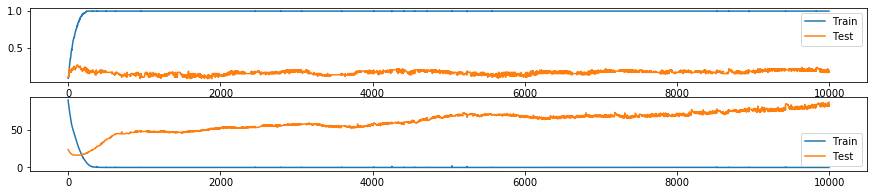

In [62]:
fig, ax = plt.subplots(2, figsize=(15,3))
ax[0].plot(train_accs)
ax[0].plot(test_accs)
ax[0].legend(['Train', 'Test'])

ax[1].plot(train_loss)
ax[1].plot(test_loss)
ax[1].legend(['Train', 'Test'])

plt.show()